In [118]:
import numpy as np 
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

<h2>Data Acquisition

In [105]:
start_date = '2015-05-03'
end_date = '2015-05-30'

events = pd.read_csv('../data/events.csv')
events = events.drop_duplicates(subset=['timestamp', 'visitorid','itemid'], keep = 'first')
events = events.assign(date=pd.Series(datetime.datetime.fromtimestamp(i/1000).date() for i in events.timestamp))
events = events.sort_values('date').reset_index(drop=True)
fd = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date()
events = events[(events.date >= fd(start_date)) & (events.date <= fd(end_date))]
times =[]
for i in events.timestamp:
    times.append(datetime.datetime.fromtimestamp(i//1000.0))
events.timestamp = times


category_df = pd.read_csv('../data/category_tree.csv')
category_df.loc[category_df.parentid!=category_df.parentid, 'parentid'] = 0

items = pd.concat(
            [pd.read_csv('../data/item_properties_part1.csv')
            , pd.read_csv('../data/item_properties_part2.csv')])
times =[]
for i in items.timestamp:
    times.append(datetime.datetime.fromtimestamp(i//1000.0))
items.timestamp = times
items = items[(items.property == 'categoryid')][['itemid','value']].drop_duplicates()
items = items.drop_duplicates(subset=['itemid','value'], keep = 'first')
items['value'] = items['value'].astype(int)
items = items.rename(columns={'value':'categoryid'})
category_df['parentid'] = category_df['parentid'].astype(int)
items = pd.merge(items, category_df, on='categoryid',  how='inner')

In [106]:
items_bkp = items.copy()
category_df_bkp = category_df.copy()
events_bkp = events.copy()

# items = items_bkp.copy()
# category_df = category_df_bkp.copy()
# events = events_bkp.copy()

Looking at visit frequencies of users:

In [107]:
visitors = events.visitorid.value_counts()
for i in [2, 5, 10, 15]:
    print(f'Visitors that appear less than {i:>2} times:\
          {round((visitors < i).mean() * 100, 2):.02f}%')

Visitors that appear less than  2 times:          71.91%
Visitors that appear less than  5 times:          94.38%
Visitors that appear less than 10 times:          98.36%
Visitors that appear less than 15 times:          99.21%


Let's have a relevant look in items

In [108]:
items = events.itemid.value_counts()
for i in [2, 10, 50, 100, 1000]:
    print(f'Items that appear less than {i:>4} times:\
          {round((items < i).mean() * 100, 2)}%')

Items that appear less than    2 times:          43.87%
Items that appear less than   10 times:          88.52%
Items that appear less than   50 times:          98.89%
Items that appear less than  100 times:          99.73%
Items that appear less than 1000 times:          100.0%


In [109]:
events

,timestamp,visitorid,event,itemid,transactionid,date
0,2015-05-04 06:19:02,1225210,view,239590,NaN,2015-05-03
1,2015-05-04 04:55:33,405346,view,361103,NaN,2015-05-03
2,2015-05-04 04:59:37,245295,view,20906,NaN,2015-05-03
3,2015-05-04 05:27:46,397243,view,387729,NaN,2015-05-03
4,2015-05-04 05:02:43,109956,view,460034,NaN,2015-05-03
...,...,...,...,...,...,...
572280,2015-05-31 06:45:55,769228,view,230568,NaN,2015-05-30
572281,2015-05-31 06:09:26,1055890,view,119636,NaN,2015-05-30
572282,2015-05-31 07:00:37,973081,view,222764,NaN,2015-05-30
572283,2015-05-31 05:50:15,852663,view,213839,NaN,2015-05-30


In [117]:
events.dtypes

timestamp        datetime64[ns]
visitorid                 int64
event                    object
itemid                    int64
transactionid           float64
date                     object
dtype: object

(array([735723., 735727., 735731., 735735., 735739., 735743., 735747.]),
 <a list of 7 Text major ticklabel objects>)

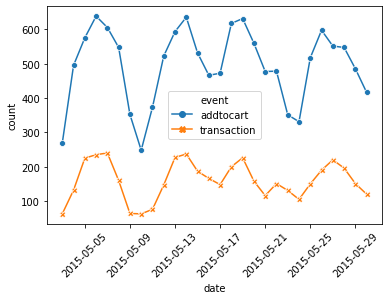

In [134]:
# events['timestamp'].apply(lambda x: x.isoweekday())
tmp = events [['date','event','visitorid']]
tmp = tmp.groupby(['date','event'], as_index = False)['visitorid'].count()
tmp = tmp.rename(columns={'visitorid':'count'})
ax = sns.lineplot(x="date", y="count",
                  hue="event", style="event",
                  markers=True, dashes=False, data=tmp[tmp['event']!='view'])
plt.xticks(rotation=45)

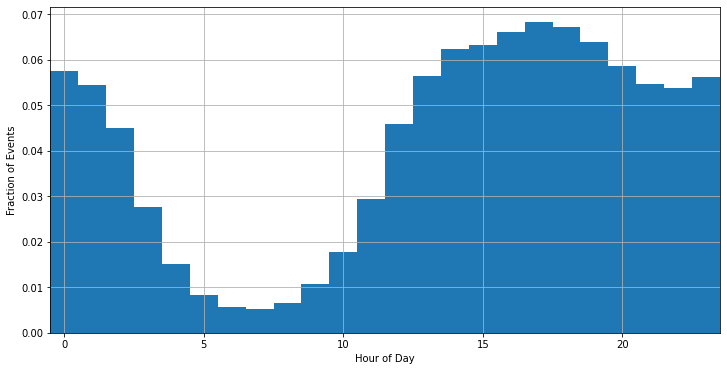

In [95]:
hour = lambda x: (datetime.datetime.fromtimestamp(x)-datetime.timedelta(hours=5)).hour
timestamp = events[['timestamp', 'event']].copy()
timestamp['timestamp'] = timestamp.timestamp / 1000
timestamp['hour'] = timestamp['timestamp'].apply(hour)

timestamp.head()
plt.figure(figsize=(12,6))
timestamp.hour.hist(bins=np.linspace(-0.5, 23.5, 25), alpha=1, density=True)
plt.xlim(-0.5, 23.5)
plt.xlabel("Hour of Day")
plt.ylabel("Fraction of Events")
plt.show()